In [ ]:
!pip install yfinance
!pip install tslearn

In [2]:
import pandas_datareader.data as web
import yfinance as yf
yf.pdr_override()

import datetime as dt
import pandas as pd


In [3]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

In [ ]:
tickers = pd.read_csv("SP500.csv")
tickers = tickers.Symbol.to_list()
start = dt.datetime(2021,1,1)
end = dt.datetime(2021,2,1)
data = yf.download(tickers[:100], start=start, end=end)['Adj Close']

In [15]:
data = data.reset_index()
data.drop('Date', axis=1, inplace=True)
data = data.dropna(how='all',axis=1)
print(len(data.columns))
data = data.fillna(-1)

82


In [16]:
data

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,COF,CPB,GOOG,GOOGL,HRB,KMX,LNT,MMM,MO,T
0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,117.608414,15.130000,151.113617,128.087097,97.798592,94.156944,106.174484,251.030594,485.339996,141.584396,...,94.769386,45.866257,86.412003,86.306503,14.601637,93.300003,47.971268,161.677658,35.854099,19.144424
2,118.569984,15.430000,150.950348,129.670715,98.809883,95.386353,107.488159,252.459732,485.690002,144.115112,...,96.997200,46.215942,87.045998,87.002502,14.760147,94.199997,47.743237,161.404877,35.783867,19.027372
3,121.821472,15.520000,159.670990,125.305801,97.956314,103.592155,107.264359,255.219955,466.309998,144.764755,...,104.009979,45.280285,86.764503,86.143997,15.067845,97.959999,48.455822,163.860077,36.363289,19.398035
4,125.063026,15.380000,161.034836,129.581635,99.004723,107.456001,108.305565,257.627930,477.739990,150.883072,...,107.254845,44.975498,89.362503,88.717003,14.834742,100.300003,46.660103,159.655167,36.679337,19.450060
5,125.955200,15.130000,163.330261,130.700073,99.524277,107.358429,108.607231,258.567596,485.100006,151.978760,...,107.090172,44.632610,90.360497,89.891502,14.834742,102.099998,46.888130,156.738998,36.512535,19.315926
6,127.035713,15.000000,164.252258,127.661469,101.147926,104.743500,107.857925,254.838257,474.239990,153.491379,...,105.879402,43.842060,88.335999,87.814499,15.039871,104.639999,46.128044,155.403214,36.301834,19.216084
7,125.865982,15.380000,169.678665,127.483315,101.853043,103.933647,105.911751,252.929520,471.649994,154.257385,...,107.283897,43.327728,87.327499,86.871498,15.254329,106.500000,45.633984,156.635513,35.933102,19.136213
8,125.875908,15.530000,164.962967,129.551941,104.330254,103.055519,109.132690,252.497345,472.049988,153.665878,...,108.562469,43.270580,87.720001,87.362503,15.328922,105.489998,46.318062,156.419174,36.073574,19.043026
9,124.934151,16.440001,162.148941,127.592178,104.780792,103.075020,107.510841,250.454453,463.269989,154.616150,...,110.809662,43.689663,87.009003,86.545998,15.030549,106.349998,45.690994,156.541443,36.091137,19.495638


In [17]:
df_list = []
def splitter(frame,df_list):
  try:
    if frame.empty:
      return None

    df = frame.iloc[:5]
    df_list.append(df)
    splitter(frame.iloc[5:],df_list)
  except:
    pass

In [18]:
splitter(data,df_list)

In [19]:
df_list

[            A    AAL         AAP        AAPL       ABBV         ABC  \
 0   -1.000000  -1.00   -1.000000   -1.000000  -1.000000   -1.000000   
 1  117.608414  15.13  151.113617  128.087097  97.798592   94.156944   
 2  118.569984  15.43  150.950348  129.670715  98.809883   95.386353   
 3  121.821472  15.52  159.670990  125.305801  97.956314  103.592155   
 4  125.063026  15.38  161.034836  129.581635  99.004723  107.456001   
 
           ABT         ACN        ADBE         ADI  ...         COF        CPB  \
 0   -1.000000   -1.000000   -1.000000   -1.000000  ...   -1.000000  -1.000000   
 1  106.174484  251.030594  485.339996  141.584396  ...   94.769386  45.866257   
 2  107.488159  252.459732  485.690002  144.115112  ...   96.997200  46.215942   
 3  107.264359  255.219955  466.309998  144.764755  ...  104.009979  45.280285   
 4  108.305565  257.627930  477.739990  150.883072  ...  107.254845  44.975498   
 
         GOOG      GOOGL        HRB         KMX        LNT         MMM  

In [20]:
tmp = []
def formatter(data,tmp):
  for i in data.columns:
      new = []
      for j in data[i].iteritems():
          new.append([j[1]])
      tmp.append(new)
  return tmp

In [21]:
listing = []
for i in df_list:
  tmp = []
  res = formatter(i,tmp)
  listing.append(tmp)

In [22]:
clustering_result = []
clustering_result.append(data.columns.tolist())

trainer = []
kms = []

for i in listing:
  X_train = TimeSeriesScalerMeanVariance().fit_transform(i)
  X_train = TimeSeriesResampler(sz=100).fit_transform(X_train)
  
  trainer.append(X_train)
  sz = X_train.shape[1]

  km = TimeSeriesKMeans(n_clusters=12,metric="dtw", max_iter=15, verbose=True)
  
  kms.append(km)
  y_pred = km.fit_predict(X_train)
  clustering_result.append(y_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

0.004 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 

[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.002 --> 


[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

2.065 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:    0.2s finished


0.875 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.860 --> 

[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.860 --> 


[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

1.673 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.756 --> 

[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.744 --> 

[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.744 --> 


[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 328 out of 328 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Us

1.312 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:    0.2s finished


0.574 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.558 --> 

[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.558 --> 

[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.558 --> 

[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.558 --> 


[Parallel(n_jobs=1)]: Done 984 out of 984 | elapsed:    0.2s finished


In [23]:
df = pd.DataFrame(clustering_result)
df, df.columns = df[1:] , df.iloc[0]
df

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,COF,CPB,GOOG,GOOGL,HRB,KMX,LNT,MMM,MO,T
1,1,3,4,5,3,2,3,3,8,1,...,2,0,3,3,3,4,7,0,3,3
2,3,7,4,10,7,9,10,9,9,2,...,7,1,9,9,11,2,10,6,1,6
3,5,5,11,4,5,3,1,5,9,11,...,8,3,9,9,1,1,0,7,1,6
4,8,1,0,9,0,5,4,7,0,0,...,4,3,0,0,3,10,0,1,5,10


In [24]:
import numpy as np
import matplotlib.pyplot as plt

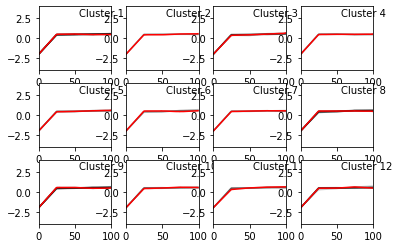

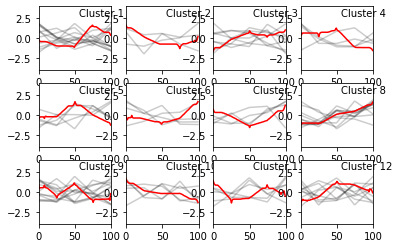

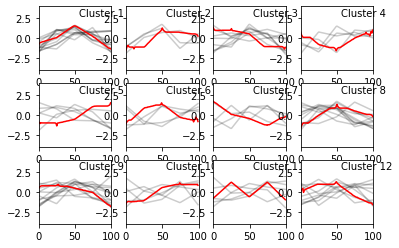

In [25]:
weeks = len(df)
filenames = []

for week in range(weeks-1):
  plt.figure()
  for yi in range(12):
      plt.subplot(3, 4, yi + 1)
      for xx in trainer[week][y_pred == yi]:
          plt.plot(xx.ravel(), "k-", alpha=.2)
          
      plt.plot(kms[week].cluster_centers_[yi].ravel(), "r-")
      plt.xlim(0, sz)
      plt.ylim(-4, 4)
      plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
              transform=plt.gca().transAxes)
      
      filename = f'{week}.png'
      filenames.append(filename)

  plt.savefig(filename)
